In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transfroms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")

cuda is available


In [4]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
sample_submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

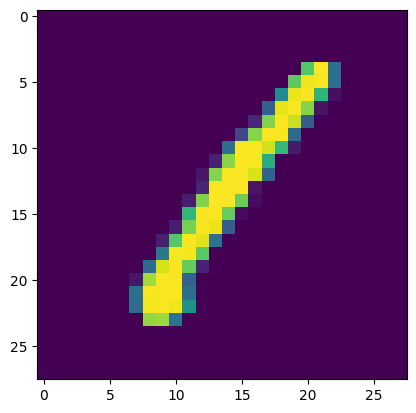

In [5]:
# 시각화
plt.imshow(train.iloc[0 , 1:].values.reshape(28,28))

In [6]:
data_x = train.iloc[:, 1:]

In [7]:
data_y = train['label']

In [8]:
# dataframe에선 안바뀜 numpy배열로 바꿔야 사진 출력되네
array_x = data_x.to_numpy()
array_y = data_y.to_numpy()

In [9]:
array_x = array_x/255
tensor_x = torch.tensor(array_x)
tensor_y = torch.tensor(array_y)

In [10]:
print(f'Previous X dimensions: {tensor_x.shape}')

Previous X dimensions: torch.Size([42000, 784])


In [11]:
tensor_x = tensor_x.reshape(tensor_x.shape[0], 28, 28)
tensor_x = torch.unsqueeze(tensor_x, 1)

In [12]:
tensor_x.shape

torch.Size([42000, 1, 28, 28])

In [13]:
mnist_dataset = TensorDataset(tensor_x, tensor_y)

In [14]:
mnist_dataset[0][0].shape

torch.Size([1, 28, 28])

In [15]:
mnist_dataset

In [16]:
train_data = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [17]:
train_data

In [18]:
# for batch in train_data:
#     inputs, labels = batch
#     print(inputs) # torch.Size([64, 1, 28, 28])
#     print(labels) # torch.Size([64])

# model

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Linear(64 * 7 * 7, num_classes) 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [20]:
model = CNN().to(device)

In [21]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3
model.train() # 학습 모드로 설정 # model.eval() : 평가 모드
model = model.cuda()

In [23]:
for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    for x, y in tqdm(train_data):
        x = x.float().cuda()
        y = y.cuda()
        out = model(x)
        cost = loss(out, y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        hypothesis = torch.nn.functional.softmax(out, dim=1)
        pred = torch.argmax(hypothesis, dim=1)
        
        correct_pred = (pred == y)
        
        epoch_loss += cost.item()
        epoch_acc += correct_pred.sum()
    
    if epoch%1 == 0:
        print("epoch : {} loss : {} acc : {}".format(epoch+1, epoch_loss, epoch_acc 
                                                     / len(train_data.dataset)))

100%|██████████| 657/657 [00:03<00:00, 174.78it/s]


epoch : 1 loss : 138.9765712665394 acc : 0.9367619156837463


100%|██████████| 657/657 [00:02<00:00, 232.07it/s]


epoch : 2 loss : 42.922245170222595 acc : 0.9800000190734863


100%|██████████| 657/657 [00:02<00:00, 235.46it/s]

epoch : 3 loss : 29.73610823682975 acc : 0.9863571524620056


In [51]:
pred[:10]

tensor([7, 0, 0, 2, 3, 0, 9, 0, 9, 5], device='cuda:0')

In [25]:
y[:10]

tensor([7, 0, 6, 2, 3, 0, 9, 0, 9, 5], device='cuda:0')

In [26]:
sample_submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [54]:
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test = test.to_numpy()
test = test/255
test = torch.tensor(test)
test = test.reshape(test.shape[0], 28, 28)
test = torch.unsqueeze(test, 1)

In [55]:
test.shape

torch.Size([28000, 1, 28, 28])

In [56]:
pred_y = model(test.float().cuda())

In [57]:
pred_y.shape

torch.Size([28000, 10])

In [58]:
sample_submission

,ImageId,Label
0,1,-5.248663
1,2,8.559029
2,3,-11.948355
3,4,2.089348
4,5,-9.165827
...,...,...
27995,27996,-13.661888
27996,27997,-8.586008
27997,27998,-15.614655
27998,27999,-10.118904


In [59]:
sample_submission['Label']

0        -5.248663
1         8.559029
2       -11.948355
3         2.089348
4        -9.165827
           ...    
27995   -13.661888
27996    -8.586008
27997   -15.614655
27998   -10.118904
27999    -9.613768
Name: Label, Length: 28000, dtype: float32

In [60]:
pred_y

tensor([[ -5.2487, -17.6394,  14.9383,  ...,  -0.8179,  -3.9582,  -4.9278],
        [  8.5590, -20.4145,  -4.6307,  ...,  -4.2089,  -6.3378,  -1.3702],
        [-11.9484, -10.3866,  -2.1545,  ...,  -4.6281,  -1.9522,   8.5123],
        ...,
        [-15.6147, -12.5439,  -5.1342,  ...,  -1.7522,  -3.9537,   1.0369],
        [-10.1189, -11.6880,  -8.4737,  ...,  -1.8222,  -4.5680,   9.8912],
        [ -9.6138, -17.2502,  13.1183,  ...,  -4.4221,   0.9163,  -4.2602]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [61]:
pred_y = torch.argmax(pred_y, dim=1)

In [62]:
pred_y

tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')

In [63]:
pred_y = pred_y.cpu()

In [64]:
pred_y = pred_y.detach().numpy()

In [65]:
sample_submission['Label'] = pred_y
sample_submission.to_csv('my baseline.csv', index = False)

In [74]:
sample_submission.shape

(28000, 2)

In [71]:
sample_submission.to_csv("CNN.csv", index = False)